# Task 2

### 1. Download Drug Dataset & Add Imports

In [1]:
# Add Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

### 2. Load Drug Dataset

In [2]:
# Load dataset
drug_dataset = pd.read_csv('../data/drug200.csv')

# Show head
head = drug_dataset.head()
print(head)


   Age Sex      BP Cholesterol  Na_to_K   Drug
0   23   F    HIGH        HIGH   25.355  drugY
1   47   M     LOW        HIGH   13.093  drugC
2   47   M     LOW        HIGH   10.114  drugC
3   28   F  NORMAL        HIGH    7.798  drugX
4   61   F     LOW        HIGH   18.043  drugY


### 3. Plot the distribution of the instances in each class

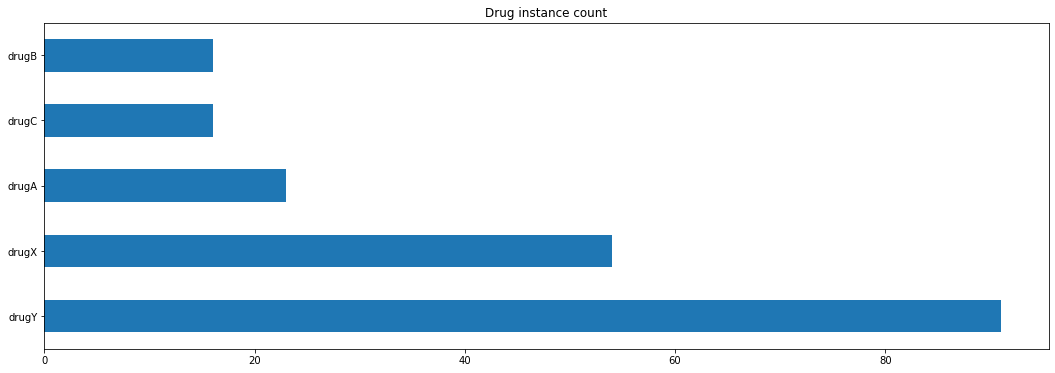

In [3]:
sp = drug_dataset['Drug'].value_counts().plot(title='Drug instance count', figsize=(18, 6),
                                         kind='barh')

plt.savefig('../out/drug-distribution.pdf')

### 4. Convert categorical data to numerical

In [4]:
cleanup_enums = {
    "Sex": { "F": 0, "M": 1 },
    "BP": {"LOW": 0, "NORMAL": 1, "HIGH": 2},
    "Cholesterol": {"LOW": 0, "NORMAL": 1, "HIGH": 2},
#     "Drug": {"drugA": 0, "drugB": 1, "drugC": 3, "drugX": 4, "drugY": 5}
}

drug_dataset = drug_dataset.replace(cleanup_enums)

print(drug_dataset.head())


   Age  Sex  BP  Cholesterol  Na_to_K   Drug
0   23    0   2            2   25.355  drugY
1   47    1   0            2   13.093  drugC
2   47    1   0            2   10.114  drugC
3   28    0   1            2    7.798  drugX
4   61    0   0            2   18.043  drugY


### 5. Split the dataset using Train/Test Split 

In [5]:
X = drug_dataset.loc[:, drug_dataset.columns != 'Drug']
Y = drug_dataset['Drug']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
predictions = {}

### 6.a. Fitting and Predictions on Gaussian Naive Bayes Classifier

In [6]:
gnb = GaussianNB()

gnb_prediction = gnb.fit(X_train, y_train).predict(X_test)
predictions.update({'Gaussian Naive Bayes Classifier': gnb_prediction})

### 6.b. Fitting and Predictions on Decision Tree Classifier

In [7]:
dtc = DecisionTreeClassifier()

dtc_prediction = dtc.fit(X_train, y_train).predict(X_test)
predictions.update({'Decision Tree Classifier': dtc_prediction})
dtc = DecisionTreeClassifier()

dtc_prediction = dtc.fit(X_train, y_train).predict(X_test)

### 6.c. Fitting and Predictions on GridSearchCV Classifier

In [8]:
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10], 'min_samples_split': [2, 4, 6]}
cv = GridSearchCV(dtc, param_grid=param_grid)

cv_prediction = cv.fit(X_train, y_train).predict(X_test)
predictions.update({'GridSearchCV Classifier': cv_prediction})

### 6.d. Fitting and Predictions on Perceptron Classifier

In [9]:
per = Perceptron()

per_prediction = per.fit(X_train, y_train).predict(X_test)
predictions.update({'Perceptron Classifier': per_prediction})

### 6.d. Fitting and Predictions on Multi-Layered Perceptron Classifier

In [10]:
base_mlp = MLPClassifier(activation='logistic', hidden_layer_sizes=100, solver='sgd', max_iter=2500)

base_mlp_prediction = base_mlp.fit(X_train, y_train).predict(X_test)
predictions.update({'Multi-Layered Perceptron (Base-MLP) Classifier': (base_mlp.get_params(False), base_mlp_prediction)})

### 6.f. Fitting and Predictions on Multi-Layered Perceptron Classifier

In [11]:
activation_functions = ['identity', 'logistic', 'relu', 'tanh']
solvers = ['sgd', 'adam']
hidden_layer_sizes = [(30, 50), (10, 10, 10)]


def generate_multi_layered_predictions(afs, ss, hls_s):
    predictions = {}
    for af in afs:
        for s in ss:
            for hls in hls_s:
                mlp_classifier = MLPClassifier(activation=af, hidden_layer_sizes=hls, solver=s, max_iter=4000)
                predictions.update(
                    {
                        str(mlp_classifier.get_params(False)): mlp_classifier.fit(X_train, y_train).predict(X_test)
                    }
                )
    return predictions


top_mlp_predictions = generate_multi_layered_predictions(activation_functions, solvers, hidden_layer_sizes)
predictions.update({'Multi-Layered Perceptron (Top-MLP) Classifier': top_mlp_predictions})

### 7. & 8. Redo steps 6, 10 times for each model and Append in a text file

In [12]:
def generate_drug_performance(a, ps):
        print('\n' + '*' * 30 + 'Try ' + str(a) + '*' * 30)
        for i, (k, p) in enumerate(ps.items()):
            print('\n ' + chr(i + 97) + ') ' + k)
            if k != 'Multi-Layered Perceptron (Top-MLP) Classifier' and k != 'Multi-Layered Perceptron (Base-MLP) Classifier':
                print('\n\t 1) Confusion matrix:\n\n\t' + np.array2string(confusion_matrix(y_test, p), prefix='\t\t\t'))
                print('\n\t 2) Confusion matrix:\n\n' + classification_report(y_test, p, zero_division=0))
            elif k == 'Multi-Layered Perceptron (Base-MLP) Classifier':
                print('\nHyper-parameters:\n\t' + str(p[0]))
                print('\n\t 1)\tConfusion matrix:\n\n\t' + np.array2string(confusion_matrix(y_test, p[1]), prefix='\t\t\t'))
                print('\n\t 2)\tConfusion matrix:\n\n' + classification_report(y_test, p[1], zero_division=0))
            else:
                print('\n')
                for i, (p1, p2) in enumerate(p.items()):
                    print('\n' + '*' * 10 + ' Top-MLP (' + str(i + 1) + ') ' + '*' * 10)
                    print('\n\tHyper-parameters:\n\t' + p1)
                    print('\n\t 1)\tConfusion matrix:\n\n\t' + np.array2string(confusion_matrix(y_test, p2), prefix='\t\t\t'))
                    print('\n\t 2)\tConfusion matrix:\n\n' + classification_report(y_test, p2, zero_division=0))


generate_drug_performance(1, predictions)
generate_drug_performance(2, predictions)


******************************Try 1******************************

 a) Gaussian Naive Bayes Classifier

	 1) Confusion matrix:

	[[ 4  0  0  0  0]
    [ 1  2  0  0  0]
    [ 0  0  3  0  0]
    [ 0  0  0 11  0]
    [ 4  0  2  0 13]]

	 2) Confusion matrix:

              precision    recall  f1-score   support

       drugA       0.44      1.00      0.62         4
       drugB       1.00      0.67      0.80         3
       drugC       0.60      1.00      0.75         3
       drugX       1.00      1.00      1.00        11
       drugY       1.00      0.68      0.81        19

    accuracy                           0.82        40
   macro avg       0.81      0.87      0.80        40
weighted avg       0.91      0.82      0.84        40


 b) Decision Tree Classifier

	 1) Confusion matrix:

	[[ 4  0  0  0  0]
    [ 1  2  0  0  0]
    [ 0  0  3  0  0]
    [ 0  0  0 11  0]
    [ 0  0  0  0 19]]

	 2) Confusion matrix:

              precision    recall  f1-score   support

       drugA  


	 2)	Confusion matrix:

              precision    recall  f1-score   support

       drugA       0.00      0.00      0.00         4
       drugB       0.17      0.33      0.22         3
       drugC       0.50      0.33      0.40         3
       drugX       0.00      0.00      0.00        11
       drugY       0.59      1.00      0.75        19

    accuracy                           0.53        40
   macro avg       0.25      0.33      0.27        40
weighted avg       0.33      0.53      0.40        40


********** Top-MLP (2) **********

	Hyper-parameters:
	{'activation': 'identity', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 4000, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'sgd', 'tol': 0.0001, 'va